In [1]:
from sklearn.model_selection import train_test_split

import pandas as pd

In [2]:
# splitting the dataset into train test and validation set 

data = pd.read_csv('../preprocessed.csv')

train_val  , test_data  =  train_test_split(data , test_size=0.2 , random_state= 42 )

train_data , validation_data = train_test_split(train_val , test_size= 0.1 , random_state= 42)

In [3]:
from operator import index

#saving the data to csv files

test_data.to_csv('test.csv', index= False)

train_data.to_csv('train.csv' , index= False)

validation_data.to_csv('val.csv' , index = False)

In [5]:
train_val.describe()

,text,summary
count,3516,3516
unique,3477,3516
top,aaj tak live tv with live election results i c...,"criticising the up chief minister, bjp mp yogi..."
freq,9,1


In [3]:
data

,text,summary
0,the daman and diu administration on wednesday ...,the administration of union territory daman an...
1,"from her special numbers to tv?appearances, bo...",malaika arora slammed an instagram user who tr...
2,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...
3,lashkar-e-taiba's kashmir commander abu dujana...,lashkar-e-taiba's kashmir commander abu dujana...
4,hotels in mumbai and other indian cities are t...,hotels in maharashtra will train their staff t...
...,...,...
4391,"mumbai, feb (pti) fruit juice concentrate m...",fruit juice concentrate maker rasna is eyeing ...
4392,former cricketer sachin tendulkar was spotted ...,former indian cricketer sachin tendulkar atten...
4393,"aamir khan, whose last film dangal told the st...","aamir khan, while talking about reality shows ..."
4394,maharahstra power minister chandrashekhar bawa...,the maharashtra government has initiated an in...


In [1]:
#using the pretrained t5-small model 
from tqdm import tqdm

import torch

from transformers import T5Tokenizer, T5ForConditionalGeneration


In [3]:
model_name = 't5-small'

#loading the tokenizer and model

tokenizer = T5Tokenizer.from_pretrained(model_name)

model = T5ForConditionalGeneration.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
#making a function to summarize the text , using max_length , min_length , length_penalty and num_beams as hyperparameters

def summarize(text, model, tokenizer, max_length=150, min_length=40, length_penalty=2.0, num_beams=4):
    
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)
    
    inputs = inputs.to(device)
    
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=length_penalty, num_beams=num_beams, early_stopping=True)
    
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Generate summaries
test_data['generated_summary'] = test_data['text'].apply(lambda x: summarize(x, model, tokenizer))

In [11]:
test_data

,text,summary,generated_summary
3942,"washington, mar (pti) a -year-old woman i...","a woman, who was arrested twice last week for ...","marci anderson wahl of everett, washington, wa..."
2658,the tea stall in guajarat's vadnagar where pri...,a tea stall in gujarat's vadnagar railway stat...,the tea stall in guajarat's vadnagar is set to...
1532,"continuing a yearly tradition, outgoing us pre...",us president barack obama has declared january...,president obama signs proclamation to declare ...
414,the supreme court on thursday rejected a petit...,the supreme court on thursday rejected a petit...,the supreme court rejected a petition seeking ...
4158,"captain amarinder singh, the congress's chief ...",congress leader captain amarinder singh will t...,"captain amarinder singh, the congress's chief ..."
...,...,...,...
2063,"new delhi, dec (pti) dismissing the petition...",while dismissing a petition against demonetisa...,"justice ashok b hinchigeri says ""laudable obje..."
3726,"there's strange, there's unfathomable, then th...",a dutch game show was slammed by people for an...,"the first episode of game show, neem je zwemsp..."
3043,taimur ali khan is undoubtedly one of the cute...,pictures of saif ali khan and kareena kapoor k...,taimur ali khan is one of the cutest star kids...
1407,a preliminary enquiry has been ordered by the...,the economic offences wing of the delhi police...,a preliminary enquiry has been ordered by the ...


In [9]:
from rouge_score import rouge_scorer, scoring

In [10]:
# Initialize the ROUGE scorer
# The ROUGE scorer allows us to calculate the ROUGE scores for our model

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

aggregator = scoring.BootstrapAggregator()


for ref, gen in zip(test_data['summary'], test_data['generated_summary']):
    
    scores = scorer.score(ref, gen)
    
    aggregator.add_scores(scores)


result = aggregator.aggregate()

In [14]:
print("ROUGE-1: ", result['rouge1'])

print("ROUGE-2: ", result['rouge2'])

print("ROUGE-L: ", result['rougeL'])

ROUGE-1:  AggregateScore(low=Score(precision=0.4877553133236592, recall=0.3590541315979636, fmeasure=0.4082635365070005), mid=Score(precision=0.49779838158982004, recall=0.3670572029078681, fmeasure=0.4167666941054268), high=Score(precision=0.507836838269845, recall=0.3755962784400046, fmeasure=0.4252769393095014))
ROUGE-2:  AggregateScore(low=Score(precision=0.22907568987834967, recall=0.16762457094202085, fmeasure=0.19073430464333807), mid=Score(precision=0.23957789775278623, recall=0.17519767516881163, fmeasure=0.19950219253300497), high=Score(precision=0.24986429548180078, recall=0.18309902633045375, fmeasure=0.20853294353212048))
ROUGE-L:  AggregateScore(low=Score(precision=0.35603848493563955, recall=0.2607843685561796, fmeasure=0.2973363048322053), mid=Score(precision=0.3672165370036532, recall=0.2690754458901813, fmeasure=0.30636262257415037), high=Score(precision=0.37658872423797224, recall=0.27643280852123653, fmeasure=0.3139865678693584))


In [15]:
import matplotlib.pyplot as plt

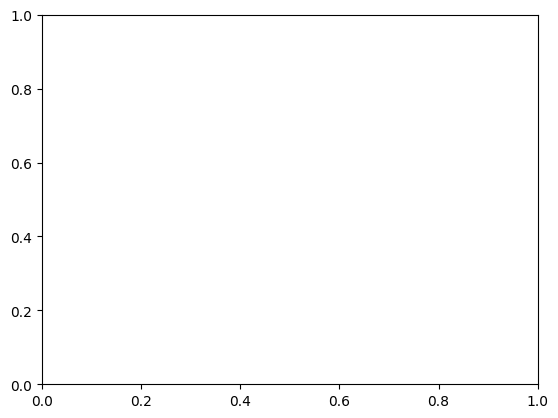

In [19]:
# Plotting the ROUGE scores for the model using a bar graph

metrics = ['Precision', 'Recall', 'F1']

rouge1_scores = [result['rouge1'].mid.precision, result['rouge1'].mid.recall, result['rouge1'].mid.fmeasure]
rouge2_scores = [result['rouge2'].mid.precision, result['rouge2'].mid.recall, result['rouge2'].mid.fmeasure]
rougeL_scores = [result['rougeL'].mid.precision, result['rougeL'].mid.recall, result['rougeL'].mid.fmeasure]


fig, ax = plt.subplots()

index = range(len(metrics))

bar_width = 0.2


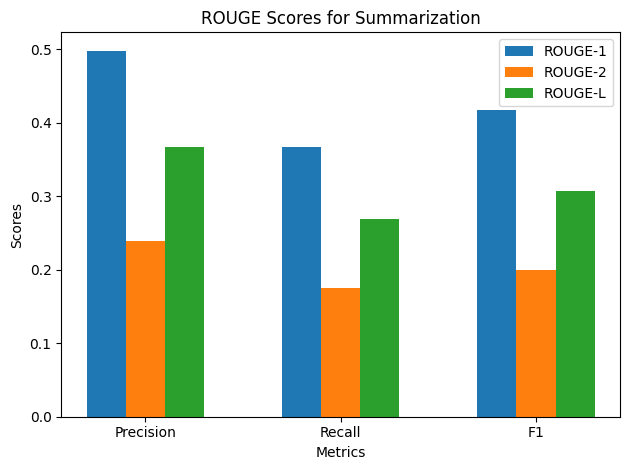

In [20]:
# Plotting the bar graph

bar1 = plt.bar(index, rouge1_scores, bar_width, label='ROUGE-1')

bar2 = plt.bar([p + bar_width for p in index], rouge2_scores, bar_width, label='ROUGE-2')

bar3 = plt.bar([p + bar_width*2 for p in index], rougeL_scores, bar_width, label='ROUGE-L')


# Adding labels
plt.xlabel('Metrics')

plt.ylabel('Scores')

plt.title('ROUGE Scores for Summarization')

plt.xticks([p + bar_width for p in index], metrics)

plt.legend()



plt.tight_layout()

plt.show()